#Homework 8

The above demonstration used unsupervised learning to find a set of features without knowing what the target (micro456) was going to be. These features are thus more general and could apply to many different things, but are not as good as if we had just learned a network with supervised learning.

Your homework is to do the comparison with supervised learning:

Create a multilayer nonlinear encoder network with 20 hidden units in the middle layer, but at least 3 nonlinear layers below and above the hidden layer, as we did in Model4 from Lecture11.  

Use x3 (from above) as inputs to the network, and micro456_scaled as the target outputs.  

Calculate the r values and compare with the network above.

In [ ]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import tensorflow as tf
from scipy import signal

#for your homework
np.random.seed(57999719)
tf.random.set_seed(57999719)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Section 1: Create Input Data x3
We will use the brain recording data again.  3 channels recorded from nearby sites in the GPi brain region.  Recordings at 24kHz, values in uV.

In [ ]:
#load the sample Brain data
#3 channels from GPi, each in microvolts.  sampling at 24.414kHz
micro123 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/micro123.csv',
                       names=['ch1','ch2','ch3'])
nDims=3
samplingFrequency = 24414
nPoints = len(micro123) # num of samples
maxTime = nPoints/samplingFrequency #samples/(samples/sec) = sec
ts_index = np.linspace(start= 0 ,stop=maxTime, num= nPoints)

#scale the range.  scale separately for each of the 3 data channels
from sklearn.preprocessing import StandardScaler
#use standard normal (mean 0, std 1) rather than min/max scaler here
scaler = StandardScaler() #scales to a Gaussian distribution
scaler.fit(micro123)
micro123_scaled = scaler.transform(micro123)
dfMic = pd.DataFrame(micro123_scaled, index = ts_index)
#make a dataframe
predict_length = 4 * int(samplingFrequency/1000.0)  #4 msec worth of samples

In [39]:
#put all 3 channels together
for c in range(nDims):
  ch = dfMic[c].values
  ln = predict_length * int(len(ch)/predict_length)
  ln -= predict_length  #for safety
  #turn into blocks of predict_length data points
  xc = np.reshape(ch[:ln], (-1,predict_length))

  #calculate for all the other offsets and add those to the end
  for offset in range(1,predict_length):
    xc = np.concatenate((xc,np.reshape(ch[offset:ln+offset], (-1,predict_length))))

  #concatenate horizontally for each of the input axes
  if c==0:
    x3 = xc
  else:
    x3 = np.concatenate((x3,xc), axis=1)

# Section 2: Create Desired Output Data micro456_scaled
We will use the brain recording data again.  3 channels recorded from nearby sites in the GPi brain region.  Recordings at 24kHz, values in uV.

In [ ]:
#load more sample Brain data
#3 channels from GPi, each in microvolts.  sampling at 24.414kHz
micro456 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/micro456.csv',
                       names=['ch4','ch5','ch6'])
nDims456=3
samplingFrequency = 24414
nPoints = len(micro456)
np.testing.assert_equal(nPoints, len(micro123))
maxTime = nPoints/samplingFrequency
ts_index = np.linspace(start= 0 ,stop=maxTime, num= nPoints)

#eigenvector transform the data to remove correlations
w,v = np.linalg.eig(micro456.T @ micro456)
micro456 = micro456 @ v

#scale the range.  scale separately for each of the data channels
scaler2 = StandardScaler()
scaler2.fit(micro456)
micro456_scaled = scaler2.transform(micro456)

# Section 3: Build Model
Create a multilayer nonlinear encoder network with 20 hidden units in the middle layer, but at least 3 nonlinear layers below and above the hidden layer, as we did in Model4 from Lecture11.

In [32]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Permute, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LayerNormalization, SimpleRNN
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D, LSTM, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Model: "model4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder input (InputLayer)      │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 150)            │        43,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Dense)                 │ (None, 80)             │        12,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle (Dense)                  │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode4 (Dense)                 │ (None, 80)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode5 (Dense)                 │ (None, 30)             │         2,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode6 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,493 (330.05 KB)

 Trainable params: 84,493 (330.05 KB)

 Non-trainable params: 0 (0.00 B)

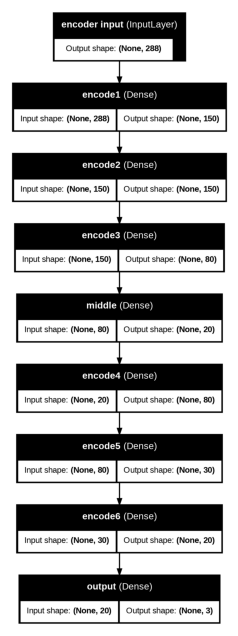

In [36]:
#build a simple autoencoder network
n_hidden_units1 = 150
n_hidden_units = 80
nDims456=3

#gelu was used instead of relu because relu was producing constant outputs
#and thus a constant loss (not training)
#flatten input as we did in lecture 13 for x3
encode_input = Input(shape=(predict_length*nDims,), name='encoder input')
encode_layer1 = Dense(units=n_hidden_units1, activation='gelu', name='encode1')(encode_input)
encode_layer2 = Dense(units=n_hidden_units1, activation='gelu', name='encode2')(encode_layer1)
encode_layer3 = Dense(units=n_hidden_units, activation='gelu', name='encode3')(encode_layer2)

middle_layer = Dense(units=20, activation='linear', name='middle')(encode_layer3)

encode_layer4 = Dense(units=n_hidden_units, activation='gelu', name='encode4')(middle_layer)
encode_layer5 = Dense(units=30, activation='gelu', name='encode5')(encode_layer4)
encode_layer6 = Dense(units=20, activation='gelu', name='encode6')(encode_layer5)

output_layer = Dense(nDims456, activation='linear', name='output')(encode_layer6)

model4 = Model(encode_input, output_layer, name ='model4')  #this is the one we will train
model4.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
#lower learning rate to help training
model4.summary()

plot_model(model4, to_file='model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(6,8))  # Adjust the figure size as needed
plt.imshow(plt.imread('model.png'))
plt.axis('off')
plt.show()

# Section 4: Fit Model and Analyze
Calculate the r values and compare with the network above.

Epoch 1/5
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - loss: 0.9984
Epoch 2/5
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - loss: 0.9977
Epoch 3/5
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.9959
Epoch 4/5
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.9931
Epoch 5/5
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.9895


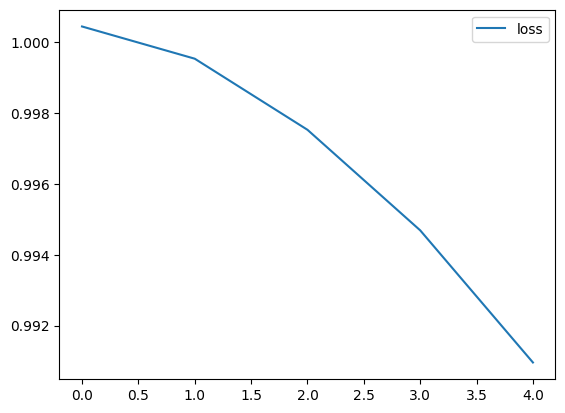

In [38]:
micro456_scaled = micro456_scaled[:len(x3),:]
#manually putting in info for fitting, no TimeSeries Generator
model4.fit(x3, micro456_scaled, epochs=5, batch_size=10)
losses = pd.DataFrame(model4.history.history)
losses.plot();

In [ ]:
#calculate the predicted outputs.
micro456_predict = model4.predict(x3)
print(micro456_predict[:5])

3120/3120 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
[[-0.00181887  0.01491808 -0.00232626]
 [-0.00181887  0.01491808 -0.00232626]
 [-0.00181887  0.01491808 -0.00232626]
 [-0.00181887  0.01491808 -0.00232626]
 [-0.00181887  0.01491808 -0.00232626]]


Output 0 has r -0.0008 and p 0.7994
Output 1 has r -0.0012 and p 0.6987
Output 2 has r -0.0020 and p 0.5241


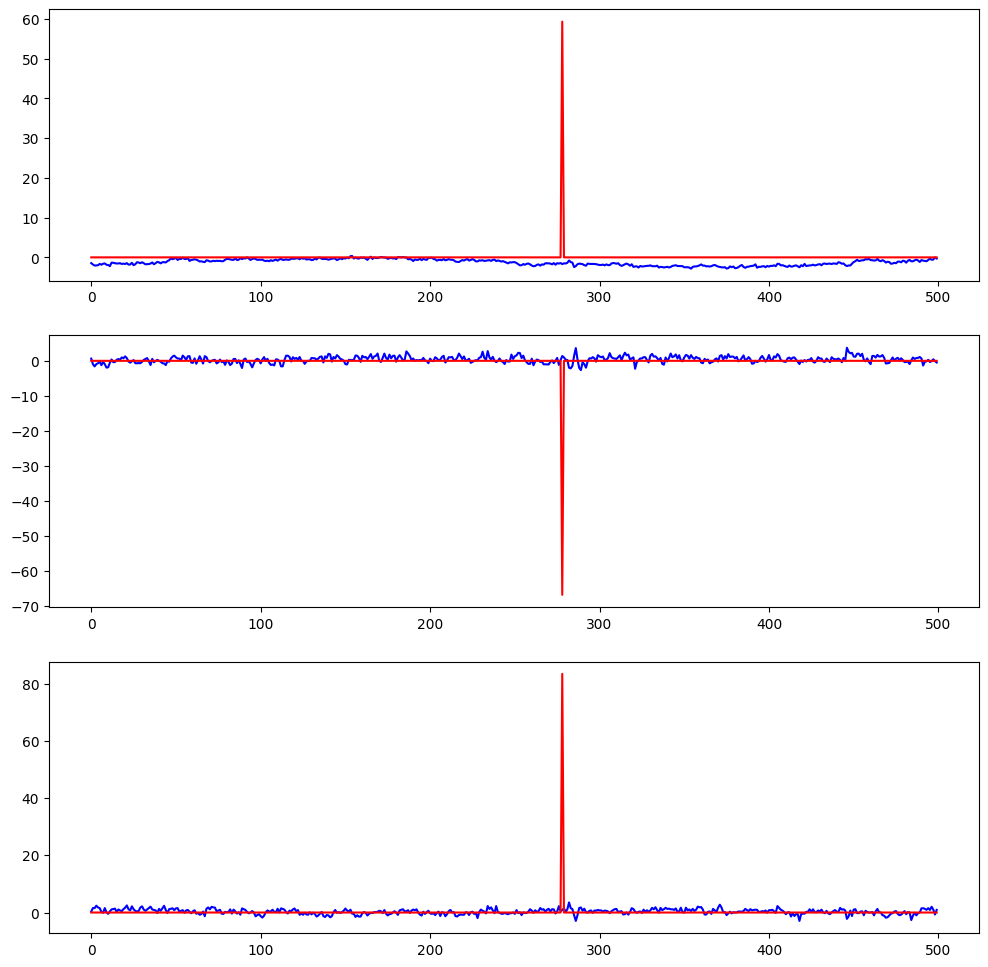

In [ ]:
#apply scaling to the prediction, so we can match the scaled inputs
scaler4 = StandardScaler()
scaler4.fit(micro456_predict)
micro456_predict_scaled = scaler4.transform(micro456_predict)

fig,ax=plt.subplots(nDims456,1,figsize=(12,12))
t1 = 2000
t2 = 2500
for s in range(nDims456):
  ax[s].plot(micro456_scaled[t1:t2,s],'b')
  ax[s].plot(micro456_predict_scaled[t1:t2,s],'r')
  slope, intercept, r_value, p_value, std_err = sp.stats.linregress(micro456_scaled[:,s], micro456_predict_scaled[:,s])
  print("Output %d has r %.4f and p %.4f" % (s, r_value, p_value))